# 🗺️ Analisis de redes en Python

**Universidad Nacional de Colombia**  

**Desarrollado por:** Yurley Tatiana Prieto  

---

> *This notebook was adapted from:*  
> <https://autogis-site.readthedocs.io/en/2019/notebooks/L6/network-analysis.html>





## 0. Introducción al Análisis de Redes

Las redes —o grafos, para usar el término matemático— proporcionan un marco poderoso para modelar y analizar relaciones entre entidades. En su forma más simple, un grafo consta de:

* **Nodos (vértices)** : los objetos o entidades que participan en las relaciones (personas, ciudades, genes, etc.).
* 
* **Aristas (enlaces)** (links):las conexiones que unen pares de nodos y describen una relación específica (amistad, carretera, interacción biológica, entre otras).

Tanto los nodos como las aristas pueden contener metadatos en forma de pares clave–valor. Por ejemplo, en una red social los nodos “Hugo” y “Eric” podrían tener un atributo  `{ "age": 25 }`, mientras que la arista entre ellos podría almacenar `{ "first_met": "2016-05-21" }`.

### ¿Por qué modelar los datos como una red?

Representar los datos como un grafo permite abordar preguntas que son difíciles de responder con tablas convencionales, como:

* ¿Quiénes son los influenciadores clave dentro de una comunidad en línea?  
* ¿Cuál es la ruta óptima entre dos ciudades en una red de transporte?  
* ¿Existen agrupamientos o comunidades densamente conectadas en la red?


Encontrar un camino más corto usando una red vial específica es un problema común en los SIG (Sistemas de Información Geográfica) que tiene muchas aplicaciones prácticas. Por ejemplo, la navegación, una de esas aplicaciones para la cual se utilizan algoritmos de enrutamiento para encontrar la ruta óptima entre dos o más puntos.

Al examinar la estructura de un grafo, podemos calcular métricas a nivel de nodo (por ejemplo, centralidad), identificar puentes críticos o detectar agrupaciones comunitarias naturales.

En Python, la biblioteca **NetworkX** (importada como nx) proporciona una API intuitiva para crear, manipular y visualizar grafos en memoria.



[1, 2, 3]
[(1, 2)]


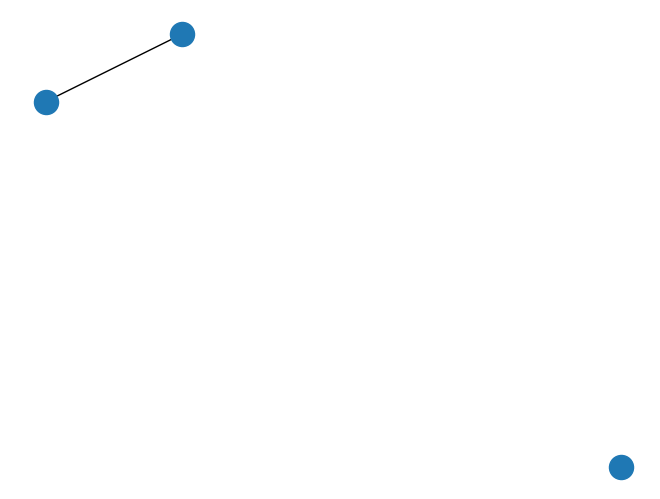

In [1]:
# Importamos la libreria 
import networkx as nx

# Crear un grafo vacío y no dirigido
G = nx.Graph()

# Add nodes and an edge
G.add_nodes_from([1, 2, 3])
G.add_edge(1, 2)

# Inspect nodes and edges
print(G.nodes())    # → [1, 2, 3]
print(G.edges())    # → [(1, 2)]

# Attach metadata
G.nodes[1]["label"] = "blue"

# Basic visualisation (requires matplotlib.pyplot as plt)
nx.draw(G)


The [NetworkX](https://networkx.github.io/documentation/) package provides various
tools to analyse networks, and implements several different routing algorithms,
such as the
[Dijkstra’s](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html)
or the
[A\*](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html#module-networkx.algorithms.shortest_paths.astar)
algorithms. Both are commonly used to find shortest paths along transport networks.

To be able to conduct network analysis, it is, of course, necessary to have a
network that is used for the analyses. The
[OSMnx](https://osmnx.readthedocs.io/) package enables us to retrieve routable
networks from OpenStreetMap for various transport modes (walking, cycling and
driving). OSMnx also wraps some of NetworkX’s functionality in a convenient way
for using it on OpenStreetMap data.

In the following section, we will use OSMnx to find the shortest path between
two points based on cyclable roads. With only the tiniest modifications, we can
then repeat the analysis for the walkable street network.




## 1. Obtain a routable network

To download OpenStreetMap data that represents the street network, we can use
it’s
[`graph_from_place()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place)
function. As parameters, it expects a place name and, optionally, a network
type.

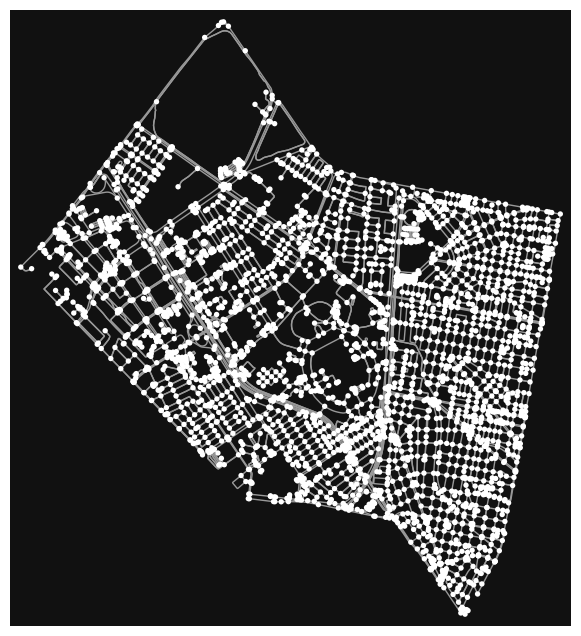

In [46]:
import osmnx

PLACE_NAME = "teusaquillo, Bogotá, Colombia"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="bike"
)
figure, ax = osmnx.plot_graph(graph)

> **Pro tip!**  
> Sometimes the shortest path might go slightly outside the defined area of interest. To account for this, we can fetch the network for a bit larger area than the district of Kamppi, in case the shortest path is not completely inside its boundaries.

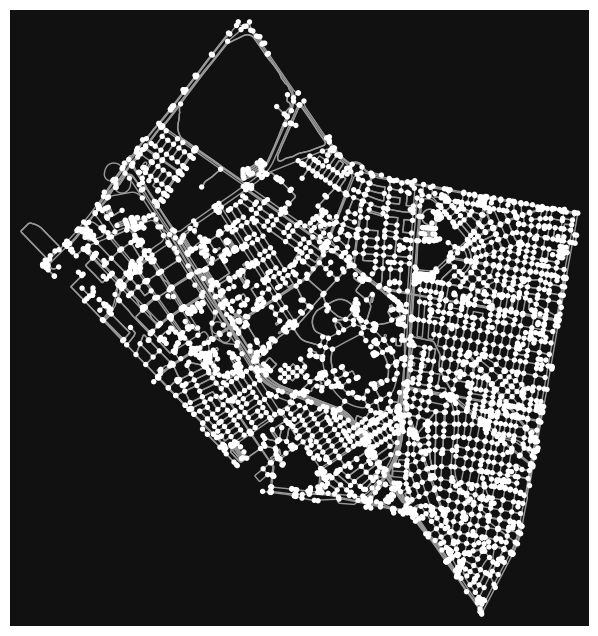

In [47]:
# Get the area of interest polygon
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Re-project the polygon to a local projected CRS (so that the CRS unit is meters)
place_polygon = place_polygon.to_crs("EPSG:3067")

# Buffer by 200 meters
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84 (required by OSMnx)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the network graph
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="bike"
)

fig, ax = osmnx.plot_graph(graph)

### 1.1. Data overview

Now that we obtained a complete network graph for the travel mode we specified
(cycling), we can take a closer look at which attributes are assigned to the
nodes and edges of the network. It is probably easiest to first convert the
network into a geo-data frame on which we can then use the tools we learnt in
earlier lessons.

To convert a graph into a geo-data frame, we can use `osmnx.graph_to_gdfs()`
(see [previous section](retrieve-data-from-openstreetmap)). Here, we can make
use of the function’s parameters `nodes` and `edges` to select whether we want
only nodes, only edges, or both (the default):

In [48]:
# Retrieve only edges from the graph
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid      highway lanes        name  oneway  \
u         v          key                                                     
253762003 500959293  0     24350411  residential     2  Carrera 24    True   
          264153961  0     89574149  residential     2    Calle 27    True   
253762008 500959410  0     89574149  residential     2    Calle 27    True   
          2863370701 0    282426636  residential   NaN  Carrera 27    True   
254530330 263368983  0     25973462  residential     2  Carrera 22    True   

                         reversed     length maxspeed  \
u         v          key                                
253762003 500959293  0      False  54.439641      NaN   
          264153961  0      False  91.009857       30   
253762008 500959410  0      False  89.638377       30   
          2863370701 0      False  57.524251      NaN   
254530330 263368983  0      False  90.869452      NaN   

                                                                   geometry  \
u         v          key                                                      
253762003 500959293  0    LINESTRING (-74.07673 4.62248, -74.07632 4.62275)   
          264153961  0    LINESTRING (-74.07673 4.62248, -74.07633 4.62176)   
253762008 500959410  0    LINESTRING (-74.07763 4.62377, -74.07716 4.62311)   
          2863370701 0     LINESTRING (-74.07763 4.62377, -74.0772 4.62405)   
254530330 263368983  0    LINESTRING (-74.07118 4.65073, -74.07119 4.650...   

                         junction bridge access service width area tunnel  
u         v          key                                                   
253762003 500959293  0        NaN    NaN    NaN     NaN   NaN  NaN    NaN  
          264153961  0        NaN    NaN    NaN     NaN   NaN  NaN    NaN  
253762008 500959410  0        NaN    NaN    NaN     NaN   NaN  NaN    NaN  
          2863370701 0        NaN    NaN    NaN     NaN   NaN  NaN    NaN  
254530330 263368983  0        NaN    NaN    NaN     NaN   NaN  NaN    NaN

The resulting geo-data frame comprises of a long list of columns. Most of them
relate to [OpenStreetMap tags](https://wiki.openstreetmap.org/wiki/Tags), and
their names are rather self-explanatory. the columns `u` and `v` describe the
topological relationship within the network: they denote the start and end node
of each edge.

| Column                                                                 | Description                         | Data type         |
|------------------------------------------------------------------------|-------------------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)                | Bridge feature                      | boolean           |
| geometry                                                              | Geometry of the feature             | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)              | Tag for roads (road type)           | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)                  | Number of lanes                     | int (or nan)      |
| [length](http://wiki.openstreetmap.org/wiki/Key:length)                | Length of feature (meters)          | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)            | Maximum legal speed limit           | int / list        |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)                    | Name of the (street) element        | str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)                | One way road                        | boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)                       | Unique ids for the element          | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                                         | The start node of edge              | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                                         | The end node of edge                | int               |



What types of streets does our network comprise of?

In [49]:
edges["highway"].value_counts()

highway
residential                3043
service                    1976
secondary                   814
tertiary                    720
cycleway                    515
primary                     192
trunk                        98
primary_link                 69
unclassified                 58
trunk_link                   47
secondary_link               36
track                        32
pedestrian                   24
tertiary_link                18
path                         10
[residential, service]       10
[service, unclassified]       2
[residential, cycleway]       2
[cycleway, service]           1
[primary, residential]        1
[service, cycleway]           1
Name: count, dtype: int64

### 1.2. Transform to projected reference system

The network data’s cartographic reference system (CRS) is WGS84 (EPSG:4326), a
geographic reference system. That means, distances are recorded and expressed
in degrees, areas in square-degrees. This is not convenient for network
analyses, such as finding a shortest path.

Again, OSMnx’s *graph* objects do not offer a method to transform their
geodata, but OSMnx comes with a separate function:
[`osmnx.project_graph()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph)
accepts an input graph and a CRS as parameters, and returns a new, transformed,
graph. If `crs` is omitted, the transformation defaults to the locally most
appropriate UTM zone.

In [50]:
# Transform the graph to UTM
graph = osmnx.project_graph(graph) 

# Extract reprojected nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

---


## 2. Analysing network properties

Now that we have prepared a routable network graph, we can turn to the more
analytical features of OSMnx, and extract information about the network.
To compute basic network characteristics, use
[`osmnx.basic_stats()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats):

In [51]:
# Calculate network statistics
osmnx.basic_stats(graph)

{'n': 3582,
 'm': 7669,
 'k_avg': 4.281965382467895,
 'edge_length_total': 544250.6017730798,
 'edge_length_avg': 70.96761008907026,
 'streets_per_node_avg': 3.024846454494696,
 'streets_per_node_counts': {0: 0, 1: 464, 2: 8, 3: 2103, 4: 990, 5: 16, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.12953657174762703,
  2: 0.002233389168062535,
  3: 0.5871021775544388,
  4: 0.27638190954773867,
  5: 0.00446677833612507,
  6: 0.00027917364600781687},
 'intersection_count': 3118,
 'street_length_total': 387122.0162603059,
 'street_segment_count': 5332,
 'street_length_avg': 72.60352893104012,
 'circuity_avg': 1.051916044537061,
 'self_loop_proportion': 0.0020630157539384846}

This does not yet yield all interesting characteristics of our network, as
OSMnx does not automatically take the area covered by the network into
consideration. We can do that manually, by, first, delineating the [complex
hull](https://en.wikipedia.org/wiki/Convex_hull) of the network (of an ’unary’
union of all its features), and then, second, computing the area of this hull.

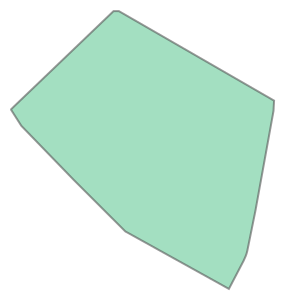

In [52]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

In [53]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 3582,
 'm': 7669,
 'k_avg': 4.281965382467895,
 'edge_length_total': 544250.6017730798,
 'edge_length_avg': 70.96761008907026,
 'streets_per_node_avg': 3.024846454494696,
 'streets_per_node_counts': {0: 0, 1: 464, 2: 8, 3: 2103, 4: 990, 5: 16, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.12953657174762703,
  2: 0.002233389168062535,
  3: 0.5871021775544388,
  4: 0.27638190954773867,
  5: 0.00446677833612507,
  6: 0.00027917364600781687},
 'intersection_count': 3118,
 'street_length_total': 387122.0162603059,
 'street_segment_count': 5332,
 'street_length_avg': 72.60352893104012,
 'circuity_avg': 1.051916044537061,
 'self_loop_proportion': 0.0020630157539384846,
 'node_density_km': 209.05906570002446,
 'intersection_density_km': 181.97827103648137,
 'edge_density_km': 31764.523258893398,
 'street_density_km': 22593.90481052184}

### 2.1. 🚀 **Now it’s your turn! — Exploring street attributes**

1. **Calculate** the total length of streets classified as `residential`, `primary`, and `secondary`.  
2. **Compare** the mean length for each class.  
3. **Visualise** the five longest street classes in a bar chart.

> 💡 *Hint:* `edges.groupby("highway")["length"].sum()` followed by `.sort_values()` will help.



In [56]:
edges_clean=edges.copy() # realizamos una copia


In [57]:
edges_clean=edges.explode("highway")# convertir en cada elemento en una fila


In [82]:
edges_length=(
    edges_clean.groupby("highway")["length"]
              .sum()
              .sort_values(ascending=False)/1000)
                

# Filtrar el DataFrame para incluir solo las clases deseadas
filtered_edges_length = edges_length.loc[['residential', 'primary', 'secondary']]

# Mostrar el resultado
display(filtered_edges_length)



highway
residential    210.734969
primary         24.061582
secondary       60.398412
Name: length, dtype: float64

In [85]:
edges_mean=(
    edges_length.groupby("highway")["length"]
              .sum()
              .sort_values(ascending=False))

display(edges_mean)

KeyError: 'Column not found: length'

<Axes: xlabel='highway'>

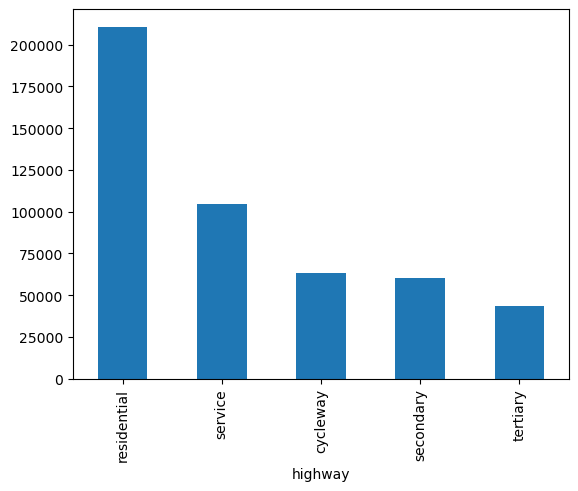

In [78]:
import matplotlib.pyplot as plt
edges_length.head(5).plot(kind="bar")
plt.ylabel(Total Longitud


In [16]:
import math
import myst_nb

myst_nb.glue("node_density_km", round(stats["node_density_km"], 1))
myst_nb.glue("edge_length_total", math.floor(stats["edge_length_total"] / 1000))

222.0

605

As we can see, now we have a lot of information about our street network that
can be used to understand its structure. We can for example see that the average
node density in our network is {glue:}`node_density_km`&nbsp;nodes/km and that
the total edge length of our network is more than
{glue:}`edge_length_total`&nbsp;kilometers.


> **Note: Centrality measures**  
> In earlier years, this course also discussed [degree centrality](https://en.wikipedia.org/wiki/Centrality). Computing network centrality has changed in OSMnx: going in-depth would be beyond the scope of this course. Please see the [OSMnx notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/06-stats-indicators-centrality.ipynb) for an example.


---


## 3. Shortest path analysis

Let’s now calculate the shortest path between two points using
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).



### 3.1. Origin and destination points 

First we need to specify the source and target locations for our route. If you
are familiar with the Kamppi area, you can specify a custom placename as a
source location. Or, you can follow along and choose these points as the origin
and destination in the analysis:
- [`"Maria 01, Helsinki"`](https://nominatim.openstreetmap.org/ui/search.html?q=Maria+01):
  a startup hub in a former hospital area.
- [`"ruttopuisto"`](https://nominatim.openstreetmap.org/ui/search.html?q=ruttopuisto),
  a park. The park’s official name is ’Vanha kirkkopuisto’, but Nominatim
  is also able to geocode the nickname.

We could figure out the coordinates for these locations manually, and create
`shapely.geometry.Point`s based on the coordinates.  However, if we would have
more than just two points, that would quickly become a chore. Instead, we can
use OSMnx to geocode the locations.

Remember to transform the origin and destination points to the same reference
system as the network data.

In [18]:
origin = (
    osmnx.geocode_to_gdf("parque el virrey, bogota")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    osmnx.geocode_to_gdf("parque nacional, bogota")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

We now have `shapely.geometry.Point`s representing the origin and destination
locations for our network analysis. In a next step, we need find these points on
the routable network before the final routing.



### 3.2. Nearest node

To route on the network, we first have to find a starting point and endpoint
that is part of the network. Use
`[osmnx.distance.nearest_nodes()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.nearest_nodes)
to return the nearest node’s ID:

In [19]:
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
origin_node_id

261629723

In [20]:
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)
destination_node_id

261629703

### 3.3. Routing

Now we are ready for routing and to find the shortest path between the
origin and target locations. We will use
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).

The function accepts three mandatory parameters: a graph, an origin node id, and
a destination node id, and two optional parameters: `weight` can be set to
consider a different *cost impedance* than the length of the route, and `cpus`
controls parallel computation of many routes.

In [21]:
# Find the shortest path between origin and destination
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)
route

[261629723,
 261629786,
 261994075,
 319189013,
 1038720466,
 9406860242,
 319188771,
 319188664,
 319188570,
 367776682,
 365650131,
 6551973736,
 310971829,
 265624295,
 265624246,
 265624228,
 265624219,
 265625389,
 261629800,
 12518388691,
 12518388690,
 12518388689,
 12518388688,
 317191083,
 316909742,
 10766308507,
 261629780,
 1037643747,
 317193879,
 1859670093,
 1859670095,
 261629752,
 9410115648,
 317194163,
 5550770010,
 261629706,
 317195804,
 317195774,
 12517396582,
 1916480710,
 12517396585,
 1916536783,
 12517396584,
 12517396583,
 261629703]

As a result we get a list of all the nodes that are along the shortest path. 

We could extract the locations of those nodes from the `nodes`
GeoDataFrame and create a LineString presentation of the points, but luckily,
OSMnx can do that for us and we can plot shortest path by using
`plot_graph_route()` function:

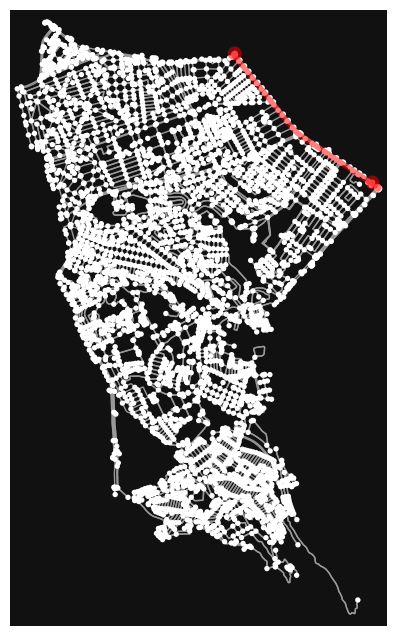

In [22]:
# Plot the shortest path
fig, ax = osmnx.plot_graph_route(graph, route)

### 3.4. 🚀 **Now it’s your turn! — Alternative routes**

1. **Calculate** a second route that avoids `motorway` and `trunk` streets.  
2. **Compare** its length with the original shortest route.  
3. **Discuss** in one sentence why constrained routes can be useful for certain users.

> 💡 You can filter `edges` before building a sub-graph or use `osmnx.utils_graph.get_route_edge_attributes`.


In [22]:
#write your code here

Nice! Now we have the shortest path between our origin and target locations.
Being able to analyze shortest paths between locations can be valuable
information for many applications.  Here, we only analyzed the shortest paths
based on distance but quite often it is more useful to find the optimal routes
between locations based on the travelled time. Here, for example we could
calculate the time that it takes to cross each road segment by dividing the
length of the road segment with the speed limit and calculate the optimal
routes by taking into account the speed limits as well that might alter the
result especially on longer trips than here.



## 4. Saving shortest paths to disk

Quite often you need to save the route into a file for further analysis and
visualization purposes, or at least have it as a GeoDataFrame object in Python.
Hence, let's continue still a bit and see how we can turn the route into a
linestring and save the shortest path geometry and related attributes into a
geopackage file.

First we need to get the nodes that belong to the shortest path:

In [23]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]
route_nodes

,y,x,street_count,highway,geometry
osmid,,,,,
261629723,507338.572411,598836.773464,4,traffic_signals,POINT (598836.773 507338.572)
261629786,507325.987311,598824.320135,4,traffic_signals,POINT (598824.32 507325.987)
261994075,507315.450683,598832.276126,4,traffic_signals,POINT (598832.276 507315.451)
319189013,507251.714344,598882.431122,3,NaN,POINT (598882.431 507251.714)
1038720466,507187.713766,598933.440719,3,NaN,POINT (598933.441 507187.714)
9406860242,507160.501086,598955.117895,3,NaN,POINT (598955.118 507160.501)
319188771,507127.103733,598981.739370,3,NaN,POINT (598981.739 507127.104)
319188664,507063.490240,599032.848478,4,traffic_signals,POINT (599032.848 507063.49)
319188570,507002.405190,599081.403016,4,traffic_signals,POINT (599081.403 507002.405)


As we can see, now we have all the nodes that were part of the shortest path as a GeoDataFrame.

Now we can create a LineString out of the Point geometries of the nodes:

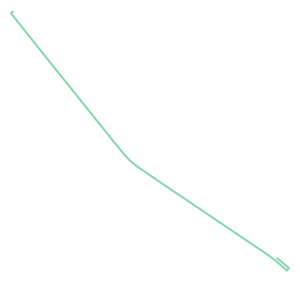

In [24]:
import shapely.geometry

# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

Now we have the route as a LineString geometry. 

Let's make a GeoDataFrame out of it having some useful information about our
route such as a list of the osmids that are part of the route and the length
of the route.

In [25]:
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (598836.773 507338.572, 598824.32 5...","[261629723, 261629786, 261994075, 319189013, 1...",2353.202577


Now we have a GeoDataFrame that we can save to disk. Let's still confirm that
everything is ok by plotting our route on top of our street network and some
buildings, and plot also the origin and target points on top of our map.

Download buildings:

In [26]:
buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

Let's now plot the route and the street network elements to verify that
everything is as it should:

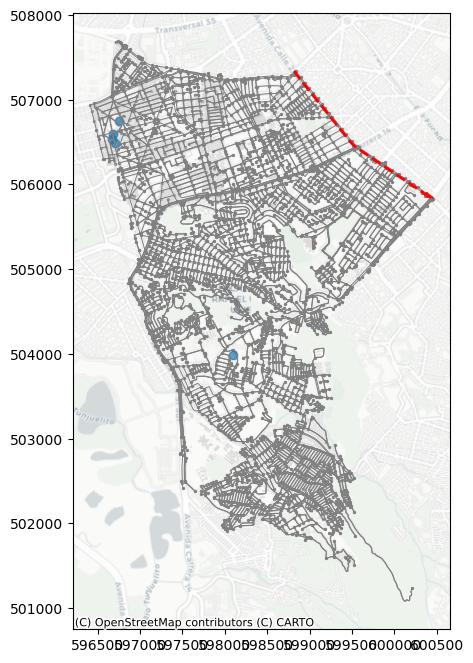

In [27]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

Great everything seems to be in order! As you can see, now we have a full
control of all the elements of our map and we can use all the aesthetic
properties that matplotlib provides to modify how our map will look like. Now
we are almost ready to save our data into disk.



## Prepare data for saving to file

The data contain certain data types (such as `list`) that should be converted
into character strings prior to saving the data to file (an alternative would be
to drop invalid columns).

In [28]:
edges.head()

osmid      highway lanes maxspeed  \
u          v          key                                          
260697628  5433647940 0    538831374      primary     2       30   
           2538226657 0    182999198  residential     2      NaN   
5433647940 6812507175 0    538831374      primary     2       30   
           6938399490 0    741106713  residential     1      NaN   
2538226657 6938399489 0    182999198  residential     2      NaN   

                                           name  oneway reversed     length  \
u          v          key                                                     
260697628  5433647940 0    Avenida Calle 51 Sur    True    False  32.384853   
           2538226657 0             Carrera 11D   False    False  44.832806   
5433647940 6812507175 0    Avenida Calle 51 Sur    True    False   4.607327   
           6938399490 0              Carrera 12   False    False  65.160534   
2538226657 6938399489 0             Carrera 11D   False    False  39.003342   

                                                                    geometry  \
u          v          key                                                      
260697628  5433647940 0    LINESTRING (597183.167 504149.659, 597168.976 ...   
           2538226657 0    LINESTRING (597183.167 504149.659, 597188.323 ...   
5433647940 6812507175 0    LINESTRING (597168.976 504178.606, 597166.963 ...   
           6938399490 0    LINESTRING (597168.976 504178.606, 597174.309 ...   
2538226657 6938399489 0    LINESTRING (597224.181 504167.74, 597259.862 5...   

                          access tunnel bridge junction service width  
u          v          key                                              
260697628  5433647940 0      NaN    NaN    NaN      NaN     NaN   NaN  
           2538226657 0      NaN    NaN    NaN      NaN     NaN   NaN  
5433647940 6812507175 0      NaN    NaN    NaN      NaN     NaN   NaN  
           6938399490 0      NaN    NaN    NaN      NaN     NaN   NaN  
2538226657 6938399489 0      NaN    NaN    NaN      NaN     NaN   NaN

In [29]:
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "tunnel",
    "access",
    "service",
    
]

#  convert selected columns to string format
edges[problematic_columns] = edges[problematic_columns].astype(str)

In [30]:
route_geom["osm_nodes"] = route_geom["osm_nodes"].astype(str)

Now we can see that most of the attributes are of type `object` that quite
often (such as ours here) refers to a string type of data.

## Save the data:

In [31]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

### 🚀 **Now it’s your turn! — Extending your analysis**

1. **Create** a 50 m buffer around the route and select buildings intersecting it.  
2. **Count** buildings both in total and by `building` tag within this corridor.  
3. **Export** the result to `buildings_along_route.geojson`.  

> 💡 Try `buildings[buildings.intersects(buffer)]` or a spatial overlay with GeoPandas.



In [32]:
# Write your script here


Great, now we have saved all the data that was used to produce the maps into a geopackage.



## Advanced reading

Here we learned how to solve a simple routing task between origin and
destination points. What about if we have hundreads or thousands of origins?
This is the case if you want to explore the travel distances to a spesific
location across the whole city, for example, when analyzing the accessibility
of jobs and services (like in the Travel Time Matrix dataset used in previous
sections). 

Check out pyrosm documentation on [working with
graphs](https://pyrosm.readthedocs.io/en/latest/graphs.html#working-with-graphs)
for more advanced examples of network analysis in python. For example,
[pandana](https://udst.github.io/pandana/) is a fast and efficient python
library for creating aggretated network analysis in no time across large
networks, and pyrosm can be used for preparing the input data for such
analysis.